# Outlier Detection

In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Langkah pertama, mengimpor pustaka seperti NumPy, Pandas, dan SciPy untuk manipulasi serta analisis data, serta matplotlib dan seaborn untuk visualisasi. Model deteksi outlier dibangun menggunakan tiga algoritma utama: Isolation Forest, Local Outlier Factor, dan One-Class SVM dari scikit-learn. Evaluasi model dilakukan dengan metrik seperti akurasi dan classification report. Untuk memastikan visualisasi yang konsisten dan informatif, ukuran grafik diatur menggunakan rcParams, sementara penggunaan seed acak (RANDOM_SEED = 42) menjamin hasil yang reproducible. Label "Normal" dan "Fraud" digunakan sebagai klasifikasi biner untuk mendeteksi anomali pada dataset.

In [2]:
data = pd.read_csv('creditcard.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<ipython-input-3-2ff48e234385>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data['Class'], sort = True)


Text(0, 0.5, 'Frequency')

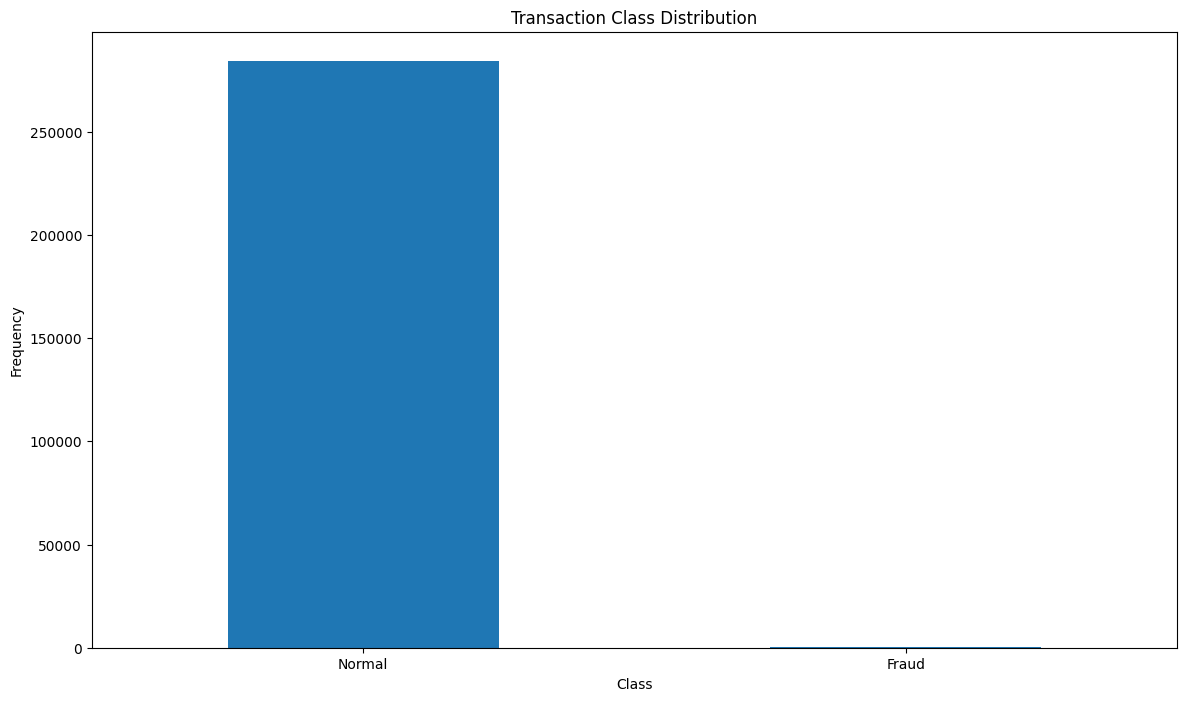

In [3]:
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

Grafik yang di tampilkan menunjukkan distribusi kelas pada dataset creditcard, di mana terlihat ketimpangan kelas yang sangat besar antara transaksi normal dan fraud. Hal ini mengindikasikan bahwa data bersifat imbalanced, dengan jumlah transaksi normal jauh lebih banyak daripada transaksi fraud, sehingga perlu penggunaan algoritma deteksi outlier.

In [4]:
fraud = data[data['Class']==1]
normal = data[data['Class']==0]

Kode ini memisahkan data menjadi dua subset: transaksi fraud (Class == 1) dan transaksi normal (Class == 0) untuk mempermudah analisis dan perbandingan antar kelas. Ini berguna dalam proses eksplorasi maupun evaluasi model.

In [5]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


Output ini menunjukkan bahwa jumlah data fraud hanya 492 baris, sedangkan data normal mencapai 284.315 baris, masing-masing dengan 31 kolom fitur.

In [6]:
fraud.Amount.describe()

,Amount
count,492.000000
mean,122.211321
std,256.683288
min,0.000000
25%,1.000000
50%,9.250000
75%,105.890000
max,2125.870000


Hasil describe() pada kolom Amount untuk transaksi fraud menunjukkan bahwa sebagian besar transaksi penipuan bernilai kecil, dengan median hanya sekitar 9.25, namun ada beberapa transaksi dengan nilai sangat tinggi hingga maksimum 2125.87, yang menyebabkan standar deviasi besar (256.68). Insight ini menunjukkan bahwa fraud bisa terjadi pada nominal kecil maupun besar, sehingga deteksi tidak bisa hanya bergantung pada nilai transaksi.

In [7]:
normal.Amount.describe()

,Amount
count,284315.000000
mean,88.291022
std,250.105092
min,0.000000
25%,5.650000
50%,22.000000
75%,77.050000
max,25691.160000


Hasil menunjukkan bahwa nilai rata-rata transaksi adalah sekitar 88.29, dengan median 22, dan nilai maksimum yang jauh lebih tinggi yaitu 25.691,16. Dibandingkan transaksi fraud, transaksi normal cenderung memiliki distribusi nilai yang lebih besar dan variatif, tetapi nilai maksimum jauh lebih ekstrem, yang dapat memengaruhi deteksi jika hanya mengandalkan jumlah uang sebagai indikator.

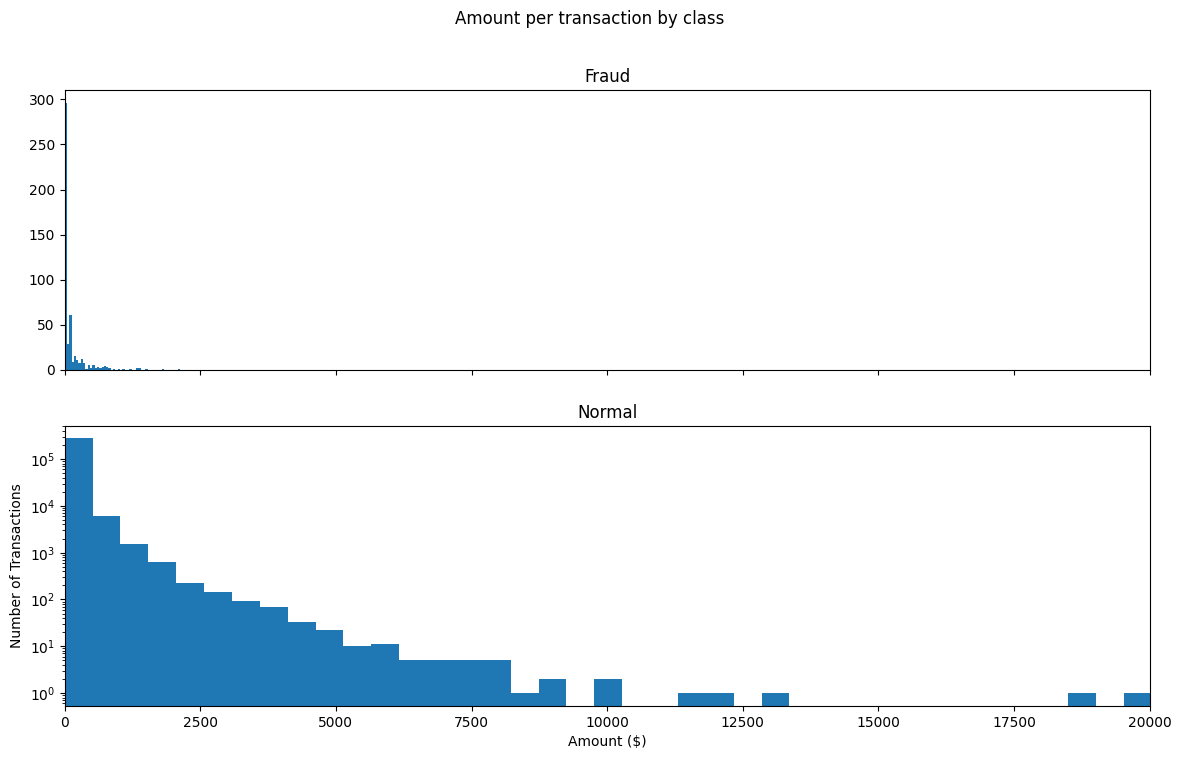

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Visualisasi histogram ini menunjukkan bahwa sebagian besar transaksi fraud terjadi pada nominal kecil di bawah $500, sementara distribusi transaksi normal lebih menyebar dan tetap tinggi bahkan pada nominal besar. Hal ini menegaskan bahwa transaksi fraud cenderung menggunakan nilai kecil untuk menghindari deteksi, sedangkan transaksi normal lebih bervariasi nilainya.

In [9]:
data.shape

(284807, 31)

In [10]:
## Mengambil sample data
data1= data.sample(frac = 0.1,random_state=1)
data1.shape

(28481, 31)

In [11]:
Fraud = data1[data1['Class']==1]
Valid = data1[data1['Class']==0]
outlier_fraction = len(Fraud)/float(len(Valid))

In [12]:
print(outlier_fraction)
print("Fraud Cases : {}".format(len(Fraud)))
print("Valid Cases : {}".format(len(Valid)))

0.0017234102419808666
Fraud Cases : 49
Valid Cases : 28432


In [13]:
# Membuat Dependent dan independent feature
columns = data1.columns.tolist()
# Filter kolom (tidak memilih kolom "Class")
columns = [c for c in columns if c not in ["Class"]]
# Menyimpan variabel yang diprediksi
target = "Class"
# Definisikan random state
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


In [14]:
## Model Outlier Detection

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X),
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto',
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine": OneClassSVM(kernel='rbf', degree=3, gamma=0.1, nu=0.05, max_iter=-1)


}

Potongan kode ini membuat sebuah dictionary classifiers yang berisi tiga model deteksi outlier untuk mendeteksi anomali atau kecurangan, yaitu:

* Isolation Forest: membangun pohon untuk mengisolasi sampel.

* Local Outlier Factor (LOF): mendeteksi anomali (outlier) berdasarkan kepadatan lokal dibandingkan tetangga terdekat.

* One-Class SVM: memisahkan data normal dari anomali dengan margin maksimum.

In [15]:
type(classifiers)

dict


Isolation Forest - Errors: 73
Accuracy Score : 0.9974368877497279
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.27      0.26        49

    accuracy                           1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481

Model Complexity (n_estimators): 100

Local Outlier Factor - Errors: 97
Accuracy Score : 0.9965942207085425
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481

Model Complexity (n_neighbors): 20

Support Vector Machine - Errors: 8516
Accuracy Score : 0.7009936448860644
Classificatio

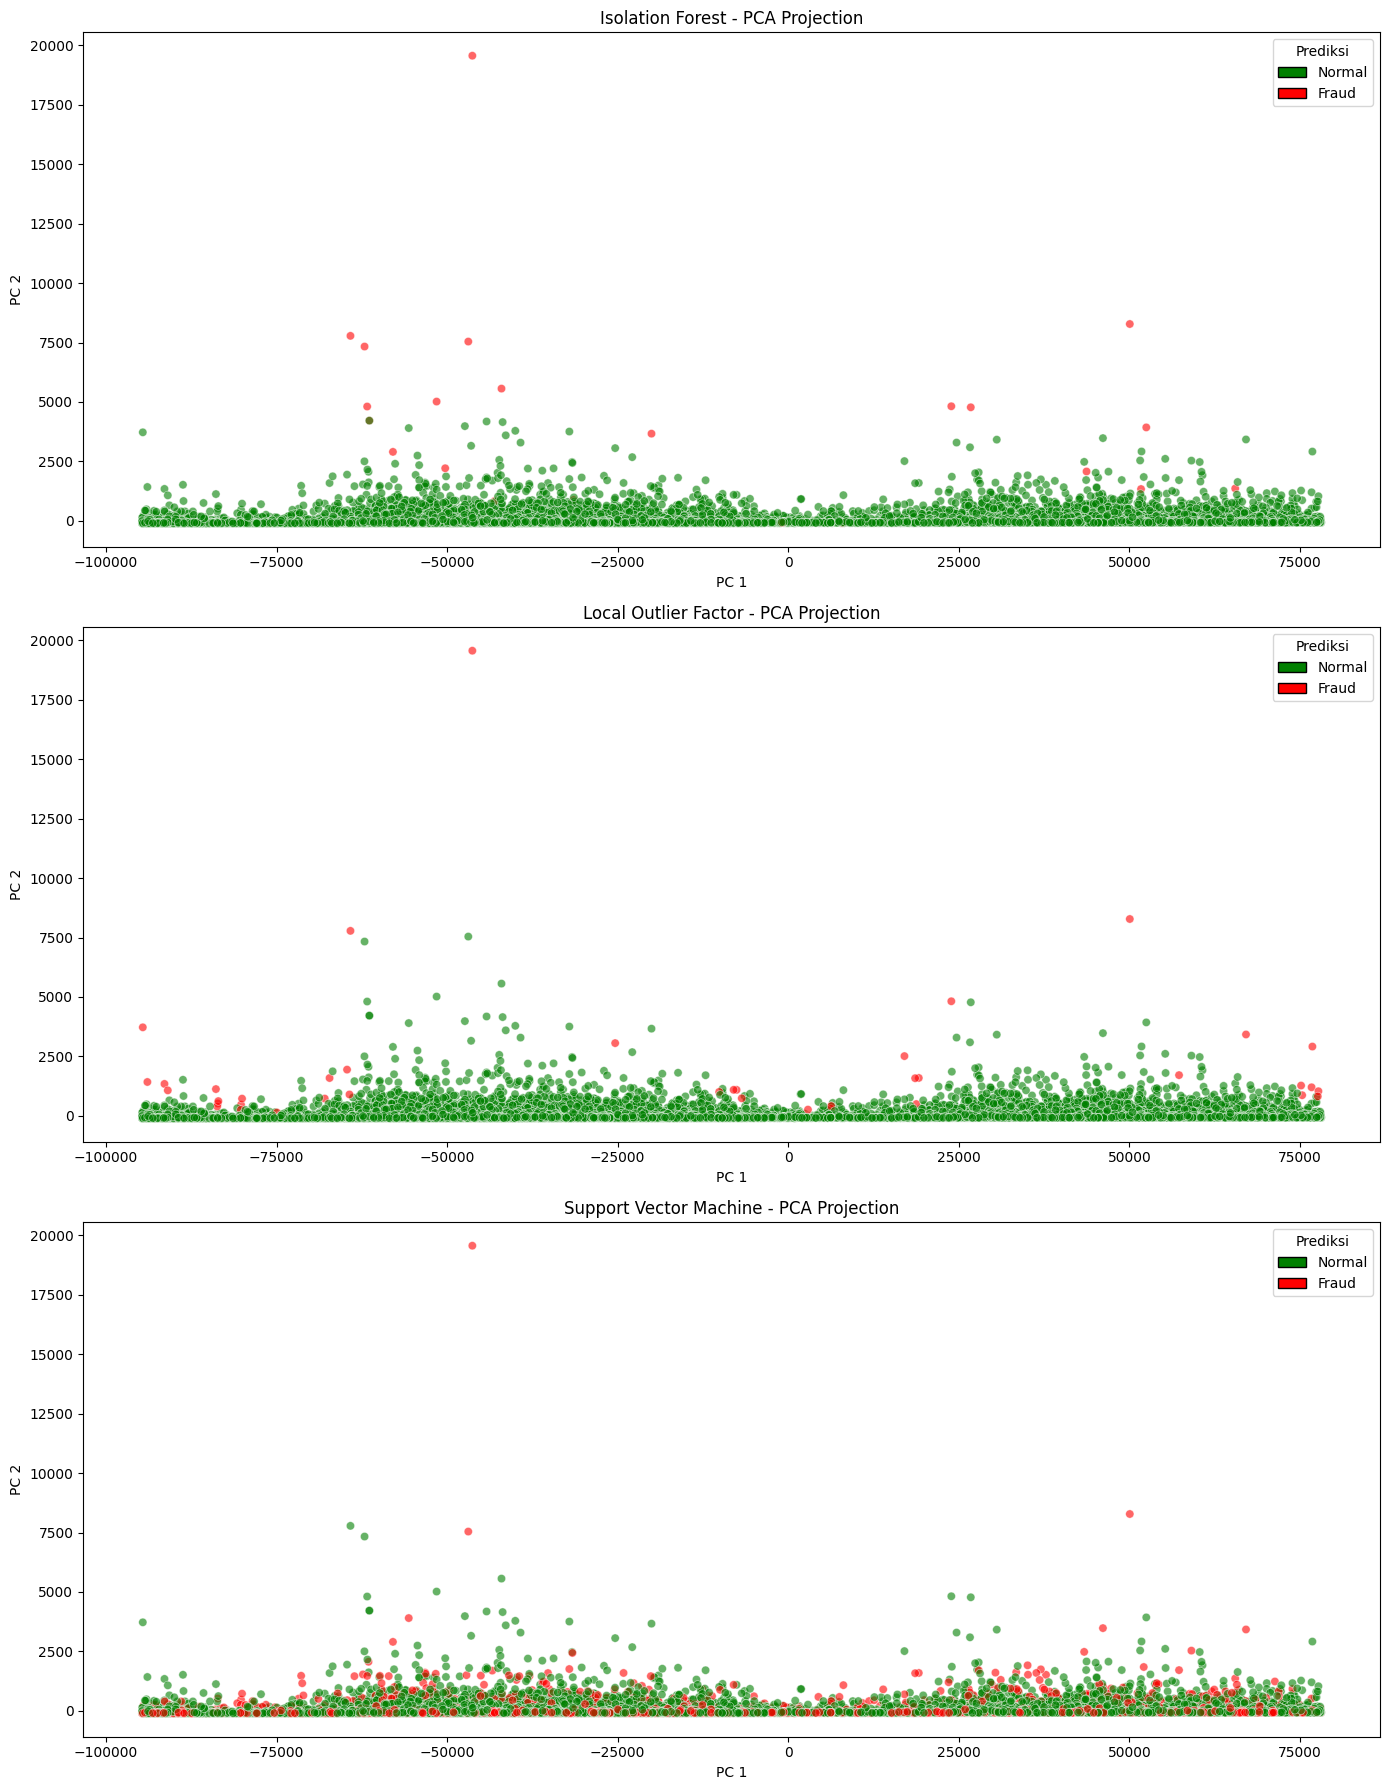

In [16]:
from sklearn.decomposition import PCA

# Lakukan reduksi dimensi ke 2D sekali saja di awal
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(14, 6 * len(classifiers)))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    # Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)

    # Reshape: 0 = Normal, 1 = Fraud
    y_pred = np.where(y_pred == 1, 0, 1)
    n_errors = (y_pred != Y).sum()

    # Metrics
    print(f"\n{clf_name} - Errors: {n_errors}")
    print("Accuracy Score :", accuracy_score(Y, y_pred))
    print("Classification Report :")
    print(classification_report(Y, y_pred))

    # Model complexity
    if clf_name == "Isolation Forest":
        print("Model Complexity (n_estimators):", clf.n_estimators)
    elif clf_name == "Local Outlier Factor":
        print("Model Complexity (n_neighbors):", clf.n_neighbors)
    elif clf_name == "Support Vector Machine":
        try:
            print("Model Complexity (support vectors):", len(clf.support_))
        except:
            print("Support vectors not available.")

    # Visualisasi berdasarkan PCA
    plt.subplot(len(classifiers), 1, i + 1)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_pred,
                    palette={0: "green", 1: "red"}, alpha=0.6)
    plt.title(f"{clf_name} - PCA Projection")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")

    # Custom legend (0: Normal, 1: Fraud)
    from matplotlib.patches import Patch
    custom_legend = [
        Patch(facecolor='green', edgecolor='black', label='Normal'),
        Patch(facecolor='red', edgecolor='black', label='Fraud')
    ]
    plt.legend(handles=custom_legend, title="Prediksi")
plt.tight_layout()
plt.show()